# Pregunta 1

# Generación y descripción del dataset

El objetivo de la predicción corresponde a predecir el precio de casas a partir de un historial de precios de casas que tiene una serie de atributos asociados.

In [1]:
import pandas as pd
url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'
df_csv = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])


In [2]:
df = df_csv.copy()
df = pd.get_dummies(df,columns=["CHAS"]) #to categorical
from sklearn.cross_validation import train_test_split
df_train,df_test= train_test_split(df,test_size=0.25, random_state=0)
df.shape
df.info()
df.describe()

from sklearn.preprocessing import StandardScaler
y_train = df_train.pop('MEDV').reshape(-1,1)
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)

y_test = df_test.pop('MEDV').reshape(-1,1)
X_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
CRIM       506 non-null float64
ZN         506 non-null int64
INDUS      506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null int64
PTRATIO    506 non-null int64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
CHAS_0     506 non-null uint8
CHAS_1     506 non-null uint8
dtypes: float64(9), int64(4), uint8(2)
memory usage: 52.5 KB


/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


Los atributos del dataset corresponden a los siguientes:

1. **CRIM**:     Tasa de crimen per capita por cada poblado
2. **ZN**:         Proporción de terreno residencial construido para lotes de más de 25.000 pies cuadrados
3. **INDUS**:      Proporción de hectareas de negocios no-retail por cada poblado
4. **CHAS**:       Si el tramo limita al río Charles
5. **NOX**:        Concentración de óxido nítrico (pertes por 10 millones)
6. **RM**:         Habitaciones promedio por morador
7. **AGE**:        Proporción de viviendas ocupadas antes de 1940
8. **DIS**:        Distancia pesada a 5 centros de empleo en Boston
9. **RAD**:        Índice de accesibilidad a autopistas cercanas
10. **TAX**:       Tasa de propiedad completa (full-value property-tax rate per) 10,000
11. **PTRATIO**:   Razó profesor-alumno por poblado
12. **B**:         $1000 (B_k - 0.63)^2$ donde $B_k$ es la proporción de gente de color por poblado
13. **LSTAT**:     porcentaje de la población con bajo estatus (Se asume económico)
14. **MEDV**:      Valor real de la vivienda

Referencia: https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names

#### Boxplot

A continuación se presenta un boxplot de los datos escalados con el objetivo de visualizar el comporamiento del dominio de las variables y ver posibles outliers en ellas.

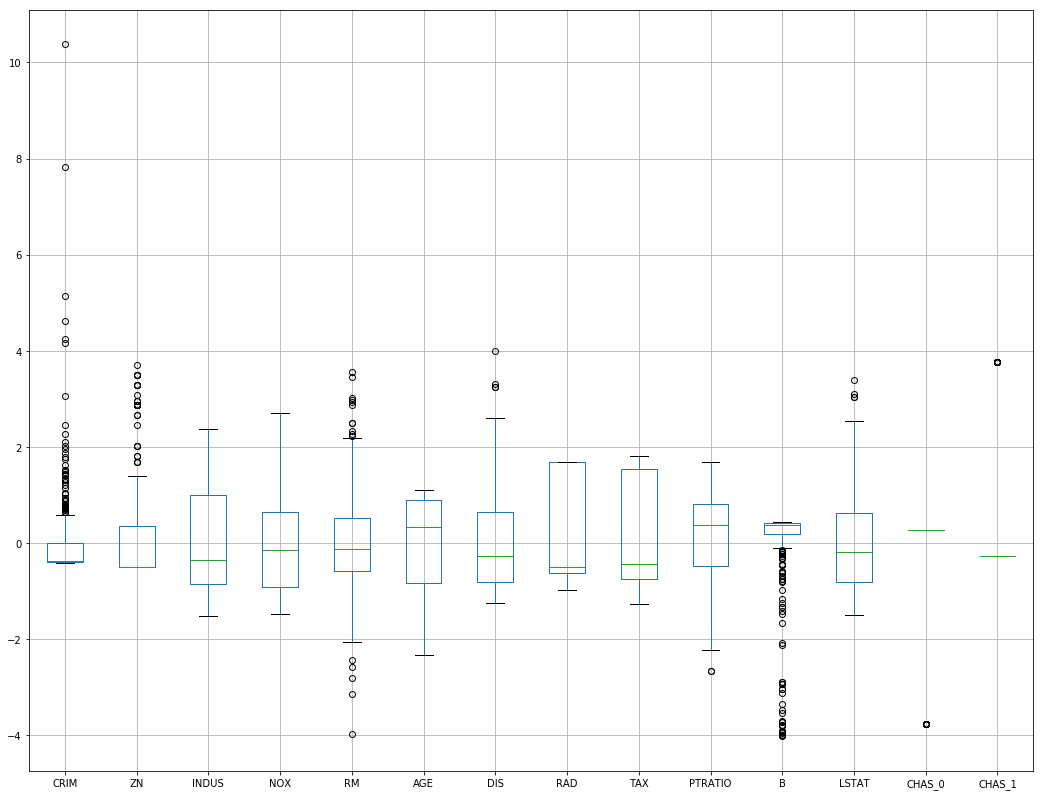

In [3]:
import matplotlib.pyplot as plt
X_train_scaled.boxplot(figsize=(18, 14))
plt.show()

Se puede notar que la variable **CRIM** posee una gran cantidad de outliers al igual que la variable **B**. Esto puede resultar en un incremento en la función de error de cualquier técnica de aprendizaje automático estadístico debido a que el modelo intentará incluir estos datos en la predicción general. Las redes neuronales no están excluidas de este efecto, por lo que se debe considerar la presencia de outliers cuando se quiere resolver problemas específicos.

Dos estrategias muy utilizadas corresponden a eliminar aquellos outliers que estén fuera de un criterio específico, o bien robustecer el modelo de red neuronal para que el efecto no influya en la capacidad de generalización de la red neuronal.

Esta pregunta corresponde a una serie de estudios para comparar los distintos efectos que tienen distintos parámetros en las soluciones de redes neuronales feedforward, por lo que la presencia de outliers es irrelevante ya que al mantener los datos fijos para todos los parámetros, el efecto no afecta las conclusioens y diferencias entre valores de parámetros.

#### Distribuciones

A continuación se muestran las distribuciones de los atributos de la predicción para su respectivo análisis.

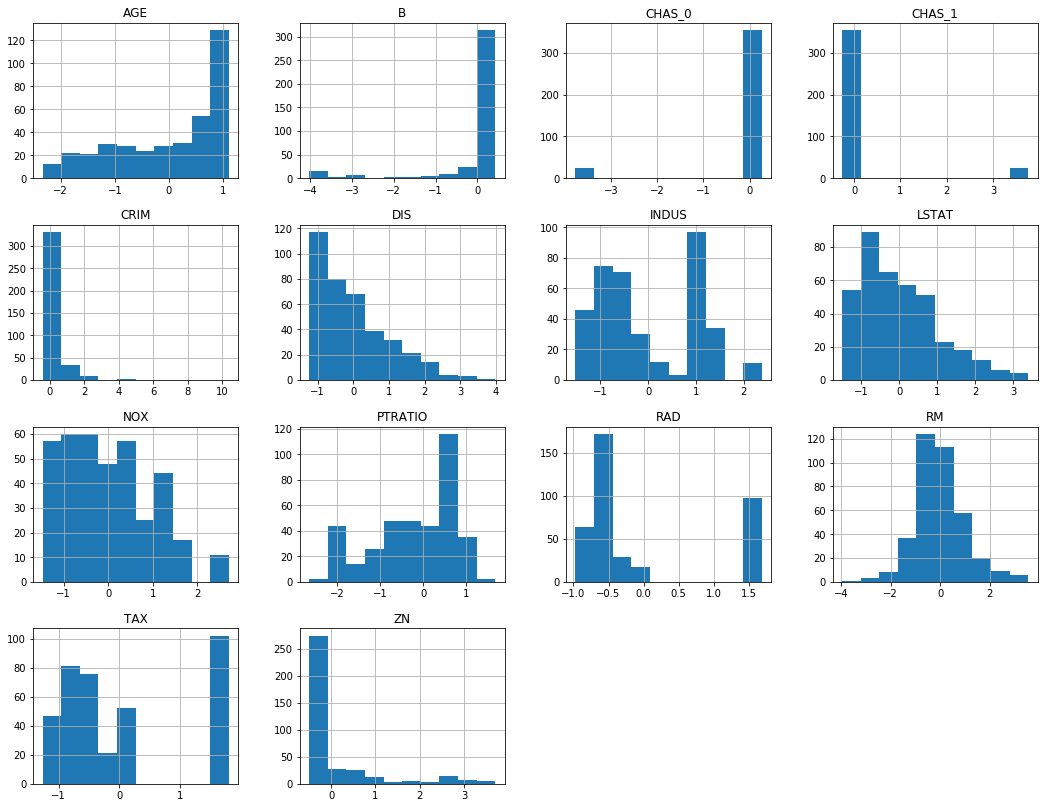

In [4]:
import matplotlib.pyplot as plt
X_train_scaled.hist(figsize=(18, 14))
plt.show()

#### Relación Feature-Feature

A continuación se presenta el diagrama de relación feature-feature con el objetivo de ver la correlación entre los atributos utilizados en la predicción. Las variables correlacionadas tienen una serie de efectos no deseables, como por ejemplo, agregar un sesgo a la solución de la red neuornal al añadir o restar peso a variables relevantes, a la inestabilidad de modelos lineales y a un incremento en la dimensionalidad que no aporta mayor valor a la solución final.

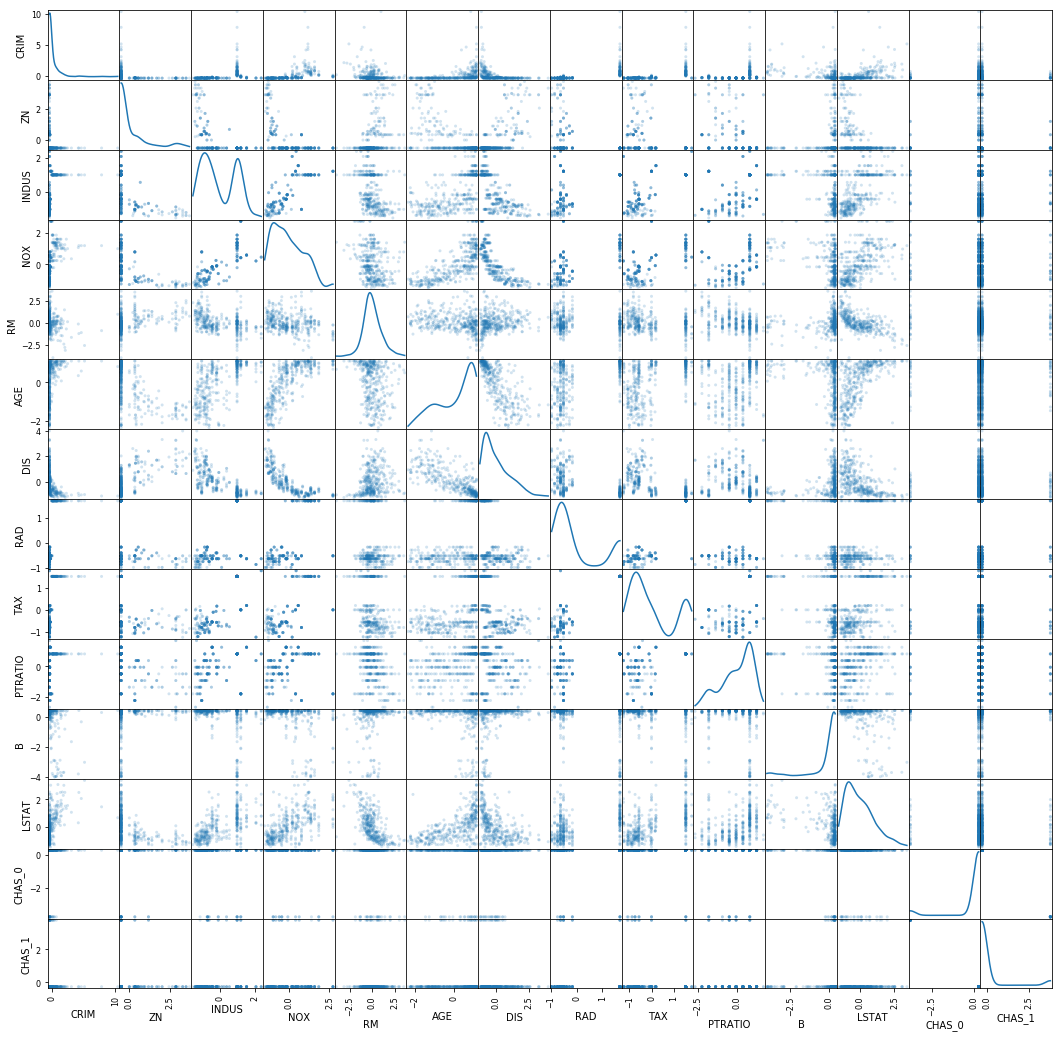

In [5]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
scatter_matrix(X_train_scaled, alpha=0.2, figsize=(18, 18), diagonal='kde')
plt.show()

Se puede observar que existe una correlación inversa entre **DIS** y **AGE** y una correlación directa más leve entre los atributos **LSTAT** y **NOX**, pero conceptualmente no están relacionadas entre sí.

Para efecto de esta pregunta en donde se realiza una comparación entre distintos parámetros, no se tomará acción frente a posibles atributos correlacionados.

# Comparación de función de activación

A continuación se definen métodos para simplificar los experimentos posteriores:

In [6]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD


def compile_network(lr=0.01, hidden_units=200, hidden_activation="sigmoid"):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
    model.add(Activation(hidden_activation))
    model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('linear'))
    sgd = SGD(lr=lr)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model
    
def fit_network(model, epochs=300):
    hist = model.fit(X_train_scaled, y_train, epochs=epochs,
        verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
    return hist


Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Entrenamiento de red neuronal con sigmoid

In [7]:
import random
random.seed(30)
model = compile_network()
hist = fit_network(model)

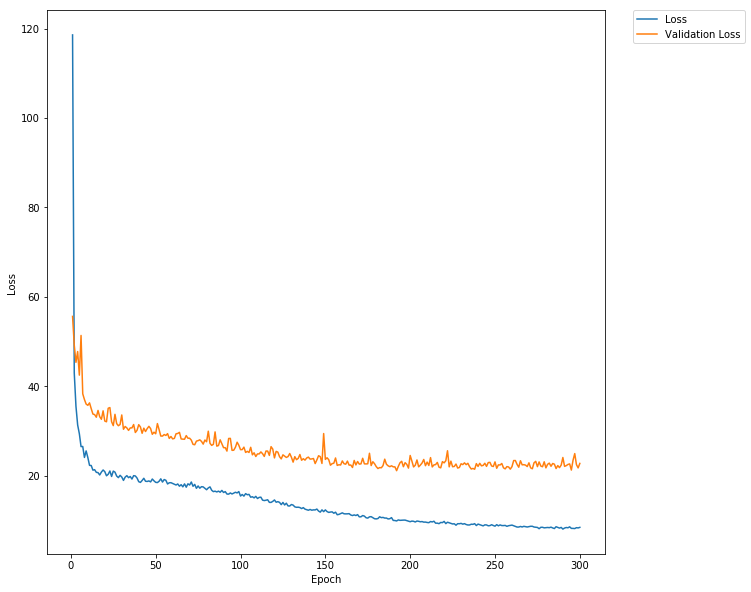

In [8]:
import matplotlib.pyplot as plt
loss_y = hist.history['loss']
loss_x = range(1, 301)

val_loss_y = hist.history['val_loss']

# Plot the loss
plt.figure(figsize=(10, 10))
plt.plot(loss_x, loss_y, label="Loss")
plt.plot(loss_x, val_loss_y, label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.show()

Para observar la convergencia dados distintas ejecuciones del experimento, se ejecuta este 20 veces utilizando distintos seeds específicos

In [9]:
import numpy as np
import random

seeds = np.linspace(20, 400, 20)

results_sigmoid = []

for seed in seeds:
    random.seed(seed)
    model = compile_network()
    hist = fit_network(model)
    results_sigmoid.append(hist)

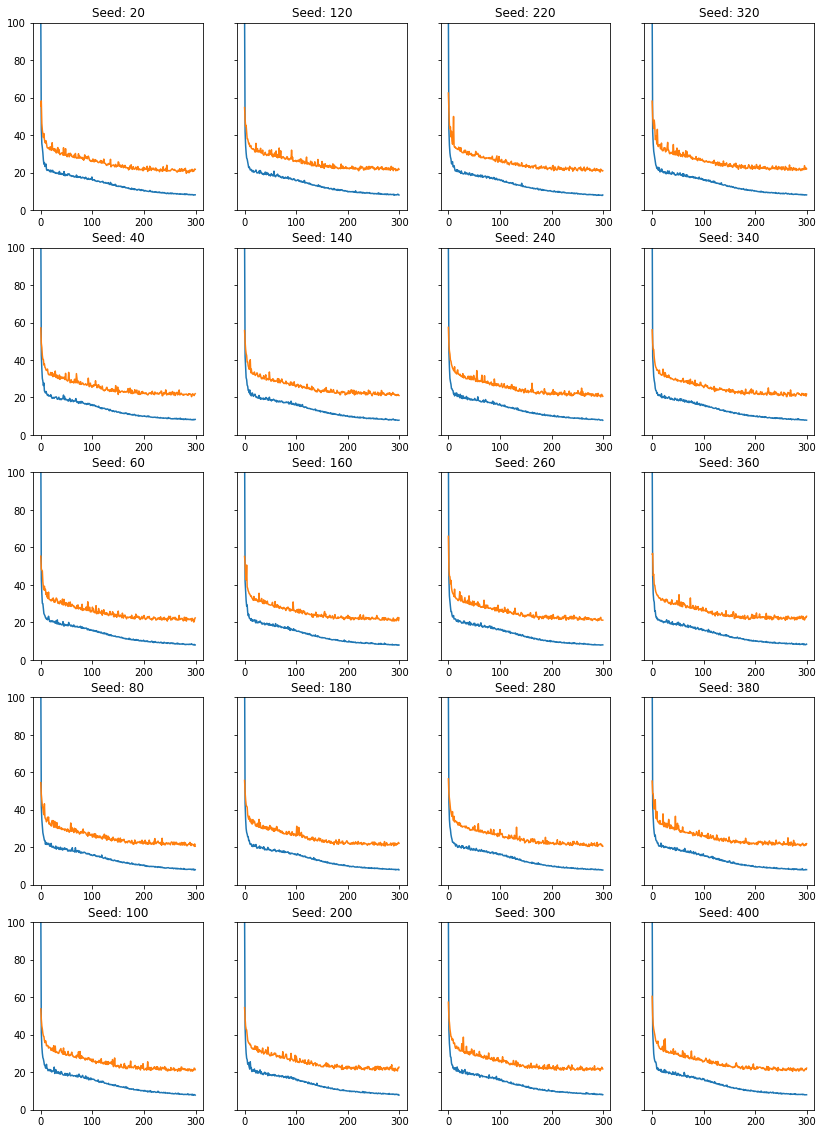

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(14, 20), sharey=True)

counter = 0
for seed in seeds:
    axes[counter % 5, counter // 5].plot(range(0, len(results_sigmoid[counter].history["loss"])), results_sigmoid[counter].history["loss"], label="Loss")
    axes[counter % 5, counter // 5].plot(range(0, len(results_sigmoid[counter].history["loss"])), results_sigmoid[counter].history["val_loss"], label="Val Loss")
    axes[counter % 5, counter // 5].set_title("Seed: %d" % (seed))
    axes[counter % 5, counter // 5].set_ylim([0, 100])
    counter += 1
plt.show()



En efecto, se puede observar que en todos los experimentos con distintas semillas se logra llegar a la convergencia de lerror de entrenamiento y de validación. Además, se puede de forma visual descartar la presencia de overfitting en las instancias.

### Entrenamiento de red neuronal con ReLU

In [11]:
import numpy as np
import random

seeds = np.linspace(20, 400, 20)

results_relu = []

for seed in seeds:
    random.seed(seed)
    model = compile_network(hidden_activation="relu")
    hist = fit_network(model)
    results_relu.append(hist)

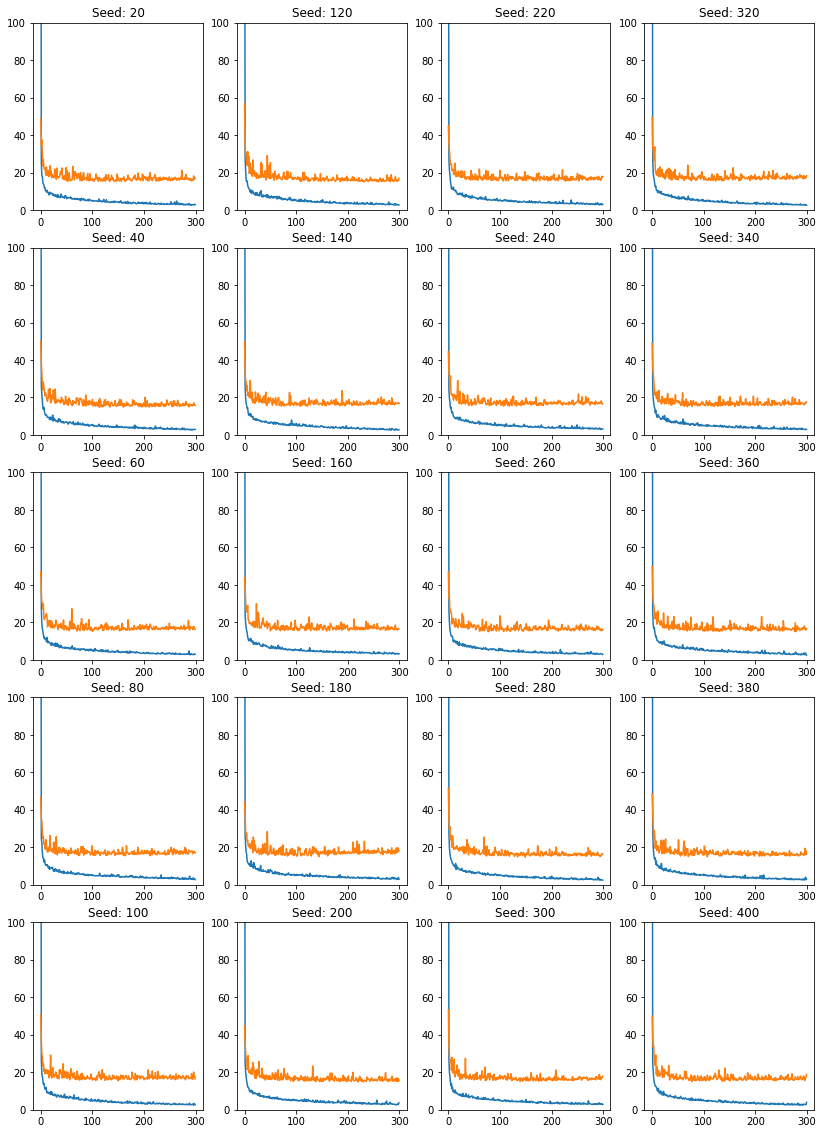

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(14, 20))

counter = 0
for seed in seeds:
    axes[counter % 5, counter // 5].plot(range(0, len(results_relu[counter].history["loss"])), results_relu[counter].history["loss"], label="Loss")
    axes[counter % 5, counter // 5].plot(range(0, len(results_relu[counter].history["loss"])), results_relu[counter].history["val_loss"], label="Val Loss")
    axes[counter % 5, counter // 5].set_title("Seed: %d" % (seed))
    axes[counter % 5, counter // 5].set_ylim([0, 100])
    counter += 1
plt.show()


### Comparación ReLU y Sigmoid

Se puede observar que en promedio la función de activación con ReLU converge de manera más rápida que sigmoid en las epochs iniciales. Además, se puede observar que ReLU presenta valores de loss iniciales tres veces mayores que sigmoid.

# Efecto del learning rate

A continuación se evalúa el efecto que tiene el learning rate sobre las redes neuronales. El learning rate es un parámetro de las redes neuronales que controla el tamaño de los pasos que ejecuta SGD durante el entrenamiento. 

### Experimento

In [13]:
activations = ["sigmoid", "relu"]

In [14]:
import numpy as np
n_lr = 10
learn_rates = np.linspace(0,0.001,n_lr)

In [15]:
import numpy as np
import random
lr_results = {}

for activation in activations:
    lr_results[activation] = []
    for learn_rate in learn_rates:
        print('Checking learning rate %f' % (learn_rate))
        random.seed(30)
        model = compile_network(lr=learn_rate, hidden_activation=activation)
        hist = fit_network(model)
        lr_results[activation].append(hist)

Checking learning rate 0.000000
Checking learning rate 0.000111
Checking learning rate 0.000222
Checking learning rate 0.000333
Checking learning rate 0.000444
Checking learning rate 0.000556
Checking learning rate 0.000667
Checking learning rate 0.000778
Checking learning rate 0.000889
Checking learning rate 0.001000
Checking learning rate 0.000000
Checking learning rate 0.000111
Checking learning rate 0.000222
Checking learning rate 0.000333
Checking learning rate 0.000444
Checking learning rate 0.000556
Checking learning rate 0.000667
Checking learning rate 0.000778
Checking learning rate 0.000889
Checking learning rate 0.001000


### Resultados Sigmoid

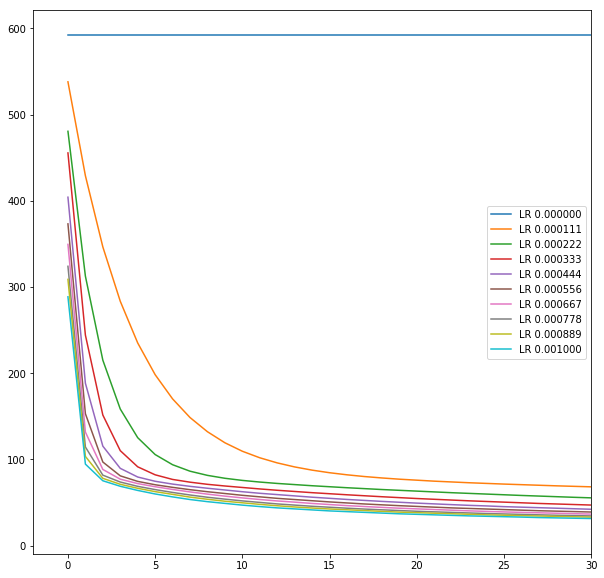

In [16]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for lr in learn_rates:
    plt.plot(range(0, len(lr_results["sigmoid"][counter].history["loss"])), lr_results["sigmoid"][counter].history["loss"], label="LR %f" % (lr))
    counter += 1
    
plt.legend()
plt.xlim(-2, 30)
plt.show()

### Resultados ReLU

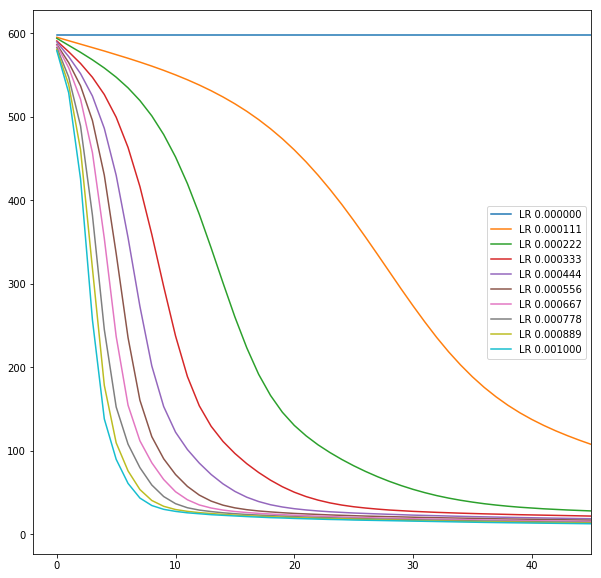

In [17]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for lr in learn_rates:
    plt.plot(range(0, len(lr_results["relu"][counter].history["loss"])), lr_results["relu"][counter].history["loss"], label="LR %f" % (lr))
    counter += 1
    
plt.legend()
plt.xlim(-2, 45)
plt.show()

# Efecto de progressive decay

El progressive decay es una técnica que permite modificar el valor del learning rate de forma dinámica durante el entrenamiento de las redes neuronales. Esto permite a la red neuronal explorar ampliamente el espacio de búsqueda de valores óptimos para los pesos de las neuronas, para luego reducir los saltos que realiza para converger en un mínimo local.

In [18]:
activations = ["sigmoid", "relu"]

In [19]:
n_decay = 10
learn_decay_list = np.logspace(-6, 0, n_decay)

def compile_network_with_decay(lr=0.01, hidden_units=200, hidden_activation="sigmoid", decay=0.0):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
    model.add(Activation(hidden_activation))
    model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('linear'))
    sgd = SGD(lr=lr, decay=decay)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model

### Experimentos

In [20]:
import numpy as np
lr_decay_results = {}

for activation in activations:
    print(activation)
    lr_decay_results[activation] = []
    for learn_rate_decay in learn_decay_list:
        print('Checking learn decay %f' % (learn_rate_decay))
        random.seed(30)
        model = compile_network_with_decay(decay=learn_rate_decay, hidden_activation=activation)
        hist = fit_network(model)
        lr_decay_results[activation].append(hist)

sigmoid
Checking learn decay 0.000001
Checking learn decay 0.000005
Checking learn decay 0.000022
Checking learn decay 0.000100
Checking learn decay 0.000464
Checking learn decay 0.002154
Checking learn decay 0.010000
Checking learn decay 0.046416
Checking learn decay 0.215443
Checking learn decay 1.000000
relu
Checking learn decay 0.000001
Checking learn decay 0.000005
Checking learn decay 0.000022
Checking learn decay 0.000100
Checking learn decay 0.000464
Checking learn decay 0.002154
Checking learn decay 0.010000
Checking learn decay 0.046416
Checking learn decay 0.215443
Checking learn decay 1.000000


### Resultados Sigmoid

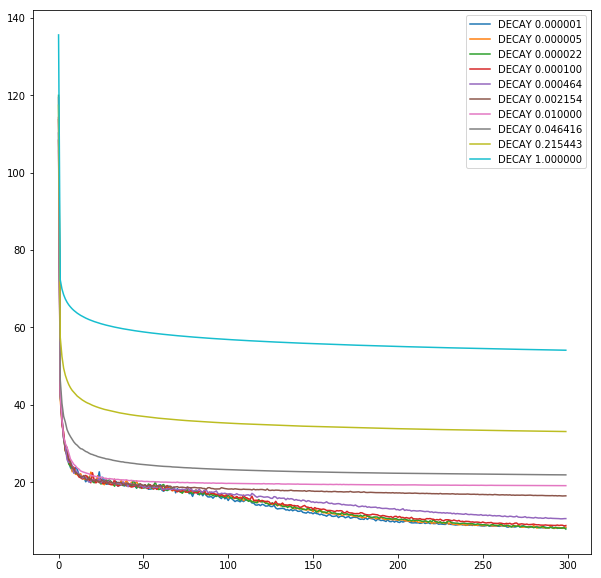

In [21]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for lr_decay in learn_decay_list:
    plt.plot(range(0, len(lr_decay_results["sigmoid"][counter].history["loss"])), lr_decay_results["sigmoid"][counter].history["loss"], label="DECAY %f" % (lr_decay))
    counter += 1
    
plt.legend()
#plt.xlim(-2, 45)
plt.show()

Haciendo un zoom hacia los valors más pequeñós

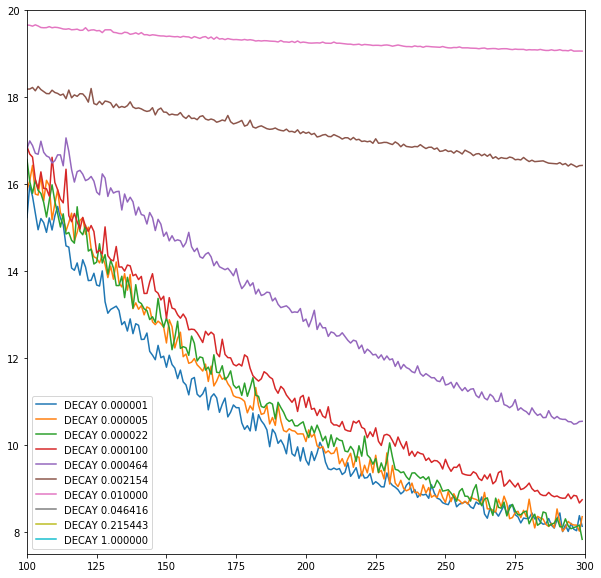

In [22]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for lr_decay in learn_decay_list:
    plt.plot(range(0, len(lr_decay_results["sigmoid"][counter].history["loss"])), lr_decay_results["sigmoid"][counter].history["loss"], label="DECAY %f" % (lr_decay))
    counter += 1
    
plt.legend()
plt.ylim(7.5, 20)
plt.xlim(100, 300)
plt.show()

### ReLU

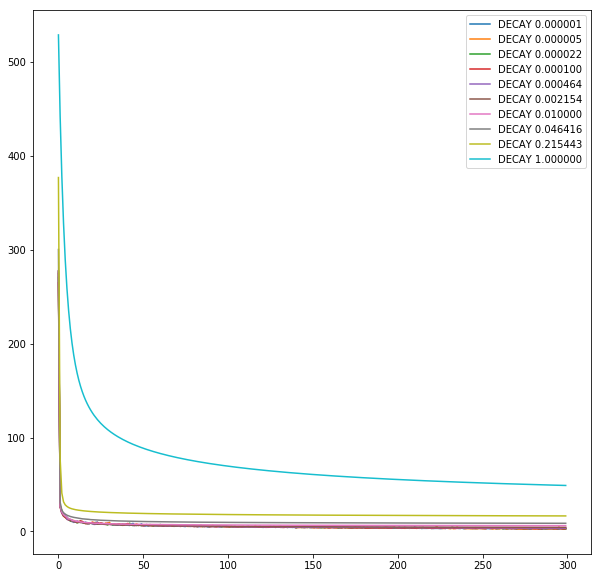

In [23]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for lr_decay in learn_decay_list:
    plt.plot(range(0, len(lr_decay_results["relu"][counter].history["loss"])), lr_decay_results["relu"][counter].history["loss"], label="DECAY %f" % (lr_decay))
    counter += 1
    
plt.legend()
#plt.xlim(-2, 45)
plt.show()

Haciendo zoom a valores más pequeños

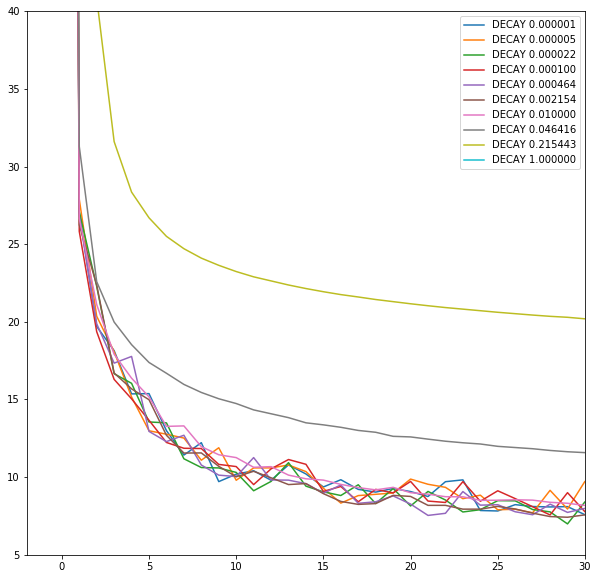

In [24]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for lr_decay in learn_decay_list:
    plt.plot(range(0, len(lr_decay_results["relu"][counter].history["loss"])), lr_decay_results["relu"][counter].history["loss"], label="DECAY %f" % (lr_decay))
    counter += 1
    
plt.legend()
plt.xlim(-2, 30)
plt.ylim(5, 40)
plt.show()

# Efecto del tamaño de batches

Un batch corresponde a la utilización de un subconjunto del conjunto original de datos para reducir el tiempo de ejecución de cada epoch en una red neuronal. El argumento para justificar el us ode batches es que el valor esperado de la función de error original se puede describir como el promedio de la función de error de todos los batches utilizados, siendo entonces cada batch un estimador del error original. 

### Experimentos

In [25]:
n_batches = 21
batch_sizes = list(map(lambda x: int(x), np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))))

def fit_network_with_batches(model, epochs=300, batch_size=32):
    hist = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size,
        verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
    return hist


In [26]:
import numpy as np
import time
batch_results = {}
batch_time_results = {}

for activation in activations:
    print(activation)
    batch_results[activation] = []
    batch_time_results[activation] = []
    
    for batch_size in batch_sizes:
        print('Checking with batch size %d' % (batch_size))
        random.seed(30)
        model = compile_network(hidden_activation=activation)
        start_time = time.time()
        hist = fit_network_with_batches(model, batch_size=batch_size)
        end_time = time.time()
        batch_time_results[activation].append(end_time - start_time)
        batch_results[activation].append(hist)

sigmoid
Checking with batch size 1
Checking with batch size 20
Checking with batch size 39
Checking with batch size 58
Checking with batch size 77
Checking with batch size 96
Checking with batch size 114
Checking with batch size 133
Checking with batch size 152
Checking with batch size 171
Checking with batch size 190
Checking with batch size 209
Checking with batch size 228
Checking with batch size 247
Checking with batch size 266
Checking with batch size 284
Checking with batch size 303
Checking with batch size 322
Checking with batch size 341
Checking with batch size 360
Checking with batch size 379
relu
Checking with batch size 1
Checking with batch size 20
Checking with batch size 39
Checking with batch size 58
Checking with batch size 77
Checking with batch size 96
Checking with batch size 114
Checking with batch size 133
Checking with batch size 152
Checking with batch size 171
Checking with batch size 190
Checking with batch size 209
Checking with batch size 228
Checking with b

### Resultados Sigmoid

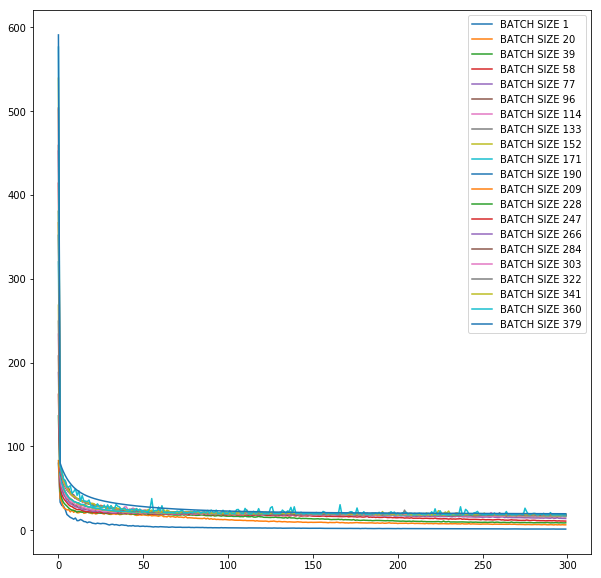

In [27]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for batch_size in batch_sizes:
    plt.plot(range(0, len(batch_results["sigmoid"][counter].history["loss"])), batch_results["sigmoid"][counter].history["loss"], label="BATCH SIZE %d" % (batch_size))
    counter += 1
    
plt.legend()
#plt.xlim(-2, 45)
plt.show()

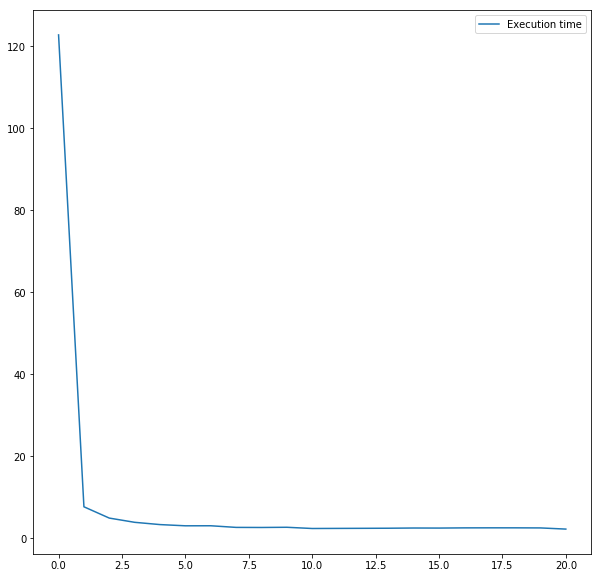

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(0, len(batch_time_results["sigmoid"])), batch_time_results["sigmoid"], label="Execution time")
    
plt.legend()
plt.show()

### ReLU

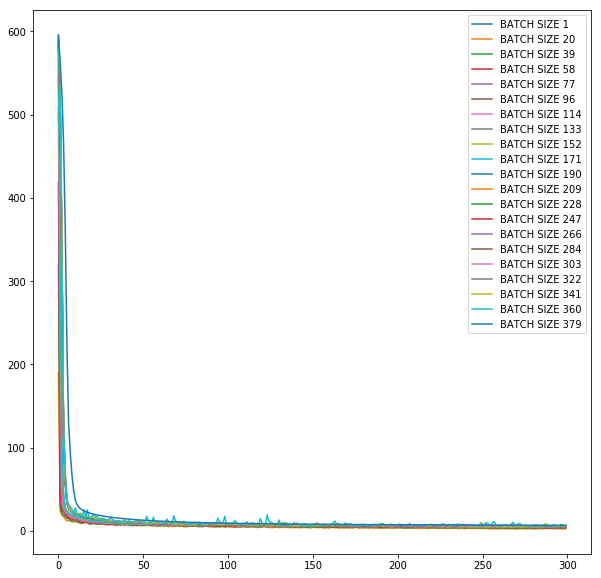

In [29]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for batch_size in batch_sizes:
    plt.plot(range(0, len(batch_results["relu"][counter].history["loss"])), batch_results["relu"][counter].history["loss"], label="BATCH SIZE %d" % (batch_size))
    counter += 1
    
plt.legend()
#plt.xlim(-2, 45)
plt.show()

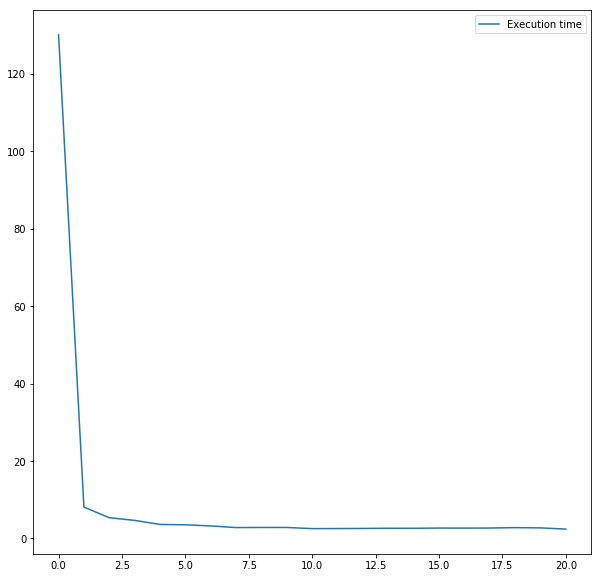

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(0, len(batch_time_results["relu"])), batch_time_results["relu"], label="Execution time")
    
plt.legend()
plt.show()

# Comparación de estrategias modernas de adaptación de learning rate

Existen técnicas más avanzadas para modificar el valor del **learning rate** de una red neuronal de forma dinámica. A continuación se realiza una comparación entre **Adagrad**, **Adadelta**, **RMSprop** y **Adam**.

In [31]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta

def compile_network_with_optimizer(lr=0.01, hidden_units=200, hidden_activation="sigmoid", optimizer="sgd"):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
    model.add(Activation(hidden_activation))
    model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('linear'))
    
    moptimizer = SGD(lr=lr)
    
    if (optimizer == "adam"):
        moptimizer = Adam(lr=lr)
    elif(optimizer == "rmsprop"):
        moptimizer = RMSprop(lr=lr)
    elif(optimizer == "adagrad"):
        moptimizer = Adagrad(lr=lr)
    elif(optimizer == "adadelta"):
        moptimizer = Adadelta(lr=lr)
    else:
        moptimizer = SGD(lr=lr)
    
    model.compile(optimizer=moptimizer, loss='mean_squared_error')
    return model

In [32]:
techniques = ["sgd", "adam", "rmsprop", "adadelta", "adagrad"]
activations = ["sigmoid", "relu"]

### Experimento

In [33]:
import numpy as np
technique_results = {}

for activation in activations: 
    print(activation)
    technique_results[activation] = []
    for technique in techniques:
        print('Checking with technique %s' % (technique))
        random.seed(30)
        model = compile_network_with_optimizer(optimizer=technique, hidden_activation=activation)
        hist = fit_network_with_batches(model)
        technique_results[activation].append(hist)

sigmoid
Checking with technique sgd
Checking with technique adam
Checking with technique rmsprop
Checking with technique adadelta
Checking with technique adagrad
relu
Checking with technique sgd
Checking with technique adam
Checking with technique rmsprop
Checking with technique adadelta
Checking with technique adagrad


### Resultados Sigmoid

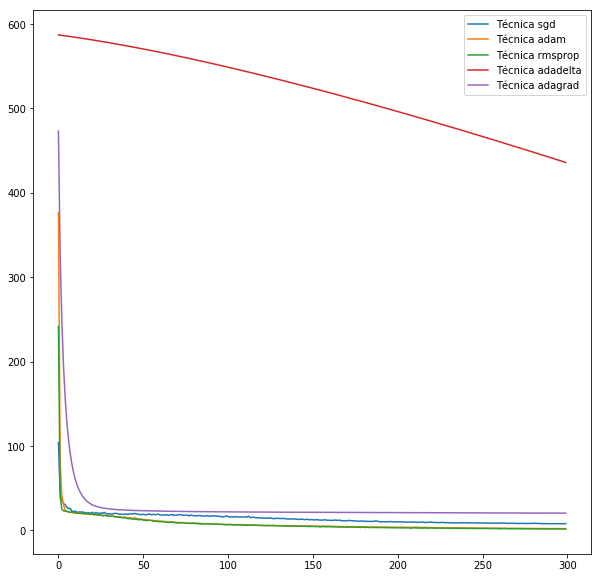

In [34]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for technique in techniques:
    plt.plot(range(0, len(technique_results["sigmoid"][counter].history["loss"])), technique_results["sigmoid"][counter].history["loss"], label="Técnica %s" % (technique))
    counter += 1
    
plt.legend()
plt.show()

### Resultados ReLU

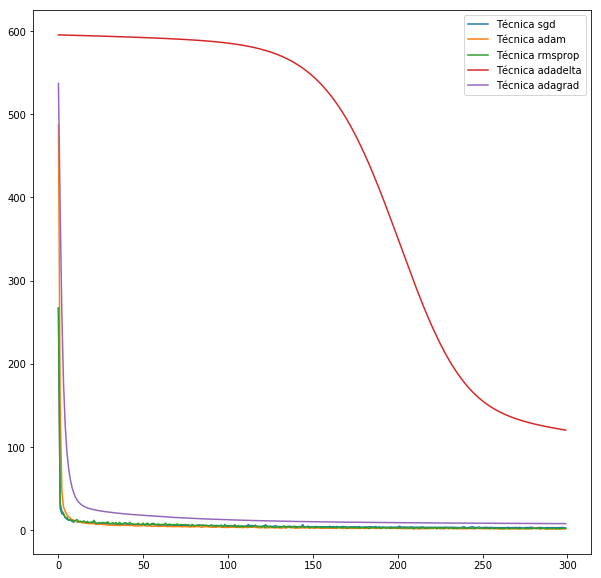

In [35]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for technique in techniques:
    plt.plot(range(0, len(technique_results["relu"][counter].history["loss"])), technique_results["relu"][counter].history["loss"], label="Técnica %s" % (technique))
    counter += 1
    
plt.legend()
plt.show()

### Efectos de la regularización

Los métodos de regularización buscan reducir el efecto del **overfitting** en la red neuronal. Pueden funcionar como penalizadores de la complejidad del modelo para que la red active neuronas solo cuando es realmente necesario, como reductores de varianza y como una forma de introducir información al modelo que se conoce desde el inicio.

A continuación se analiza el efecto que tiene la regularización en las distintas capas de la red.

### Experimentos

In [36]:
from keras import regularizers
def compile_network_with_regularization(lr=0.01, hidden_units=200, hidden_activation="sigmoid", reg1=None, reg2=None):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform', W_regularizer=reg1))
    model.add(Activation(hidden_activation))
    model.add(Dense(1, kernel_initializer='uniform', W_regularizer=reg2))
    model.add(Activation('linear'))
    sgd = SGD(lr=lr)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model

regularization_values = np.linspace(0.001, 1, 10)
regularizer_combinations = [("l1", None), ("l2", None), (None, "l1"), (None, "l2"), ("l1", "l2"), ("l2", ("l1"), (None, None))]
print(regularization_values)

[0.001 0.112 0.223 0.334 0.445 0.556 0.667 0.778 0.889 1.   ]


In [37]:
import numpy as np
import keras
regularization_results = {}

# For each activation function
for activation in activations:
    regularization_results[activation] = {}
    print("Activation %s" % (activation))
    # For each regularizer combination
    for reg_comb in regularizer_combinations:
        
        layer1 = 'None' if reg_comb[0] is None else  reg_comb[0]
        layer2 = 'None' if reg_comb[1] is None else  reg_comb[1]
        key = "%s_%s" % (layer1, layer2)
        print("-Combination %s" % (key))
        
        
        
        regularization_results[activation][key] = []
        for reg_val in regularization_values:
            print('--Checking value %f' % (reg_val))
            random.seed(30)
            
            reg_func1 = None
            reg_func2 = None
            
            if(layer1 == "l1"):
                reg_func1 = keras.regularizers.l1(reg_val)
            elif(layer1 == "l2"):
                reg_func1 = keras.regularizers.l2(reg_val)
                
            if(layer2 == "l1"):
                reg_func2 = keras.regularizers.l1(reg_val)
            elif(layer2 == "l2"):
                reg_func2 = keras.regularizers.l2(reg_val)
            
            
            model = compile_network_with_regularization(hidden_activation=activation, reg1=reg_func1, reg2=reg_func2)
            hist = fit_network(model, epochs=75)
            regularization_results[activation][key].append(hist)

Activation sigmoid
-Combination l1_None
--Checking value 0.001000


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, input_dim=14, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", kernel_regularizer=None)`
  


--Checking value 0.112000
--Checking value 0.223000
--Checking value 0.334000
--Checking value 0.445000
--Checking value 0.556000
--Checking value 0.667000
--Checking value 0.778000
--Checking value 0.889000
--Checking value 1.000000
-Combination l2_None
--Checking value 0.001000
--Checking value 0.112000
--Checking value 0.223000
--Checking value 0.334000
--Checking value 0.445000
--Checking value 0.556000
--Checking value 0.667000
--Checking value 0.778000
--Checking value 0.889000
--Checking value 1.000000
-Combination None_l1
--Checking value 0.001000


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, input_dim=14, kernel_initializer="uniform", kernel_regularizer=None)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  


--Checking value 0.112000
--Checking value 0.223000
--Checking value 0.334000
--Checking value 0.445000
--Checking value 0.556000
--Checking value 0.667000
--Checking value 0.778000
--Checking value 0.889000
--Checking value 1.000000
-Combination None_l2
--Checking value 0.001000
--Checking value 0.112000
--Checking value 0.223000
--Checking value 0.334000
--Checking value 0.445000
--Checking value 0.556000
--Checking value 0.667000
--Checking value 0.778000
--Checking value 0.889000
--Checking value 1.000000
-Combination l1_l2
--Checking value 0.001000
--Checking value 0.112000
--Checking value 0.223000
--Checking value 0.334000
--Checking value 0.445000
--Checking value 0.556000
--Checking value 0.667000
--Checking value 0.778000
--Checking value 0.889000
--Checking value 1.000000
-Combination l2_l1
--Checking value 0.001000
--Checking value 0.112000
--Checking value 0.223000
--Checking value 0.334000
--Checking value 0.445000
--Checking value 0.556000
--Checking value 0.667000
--Che

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:1506: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


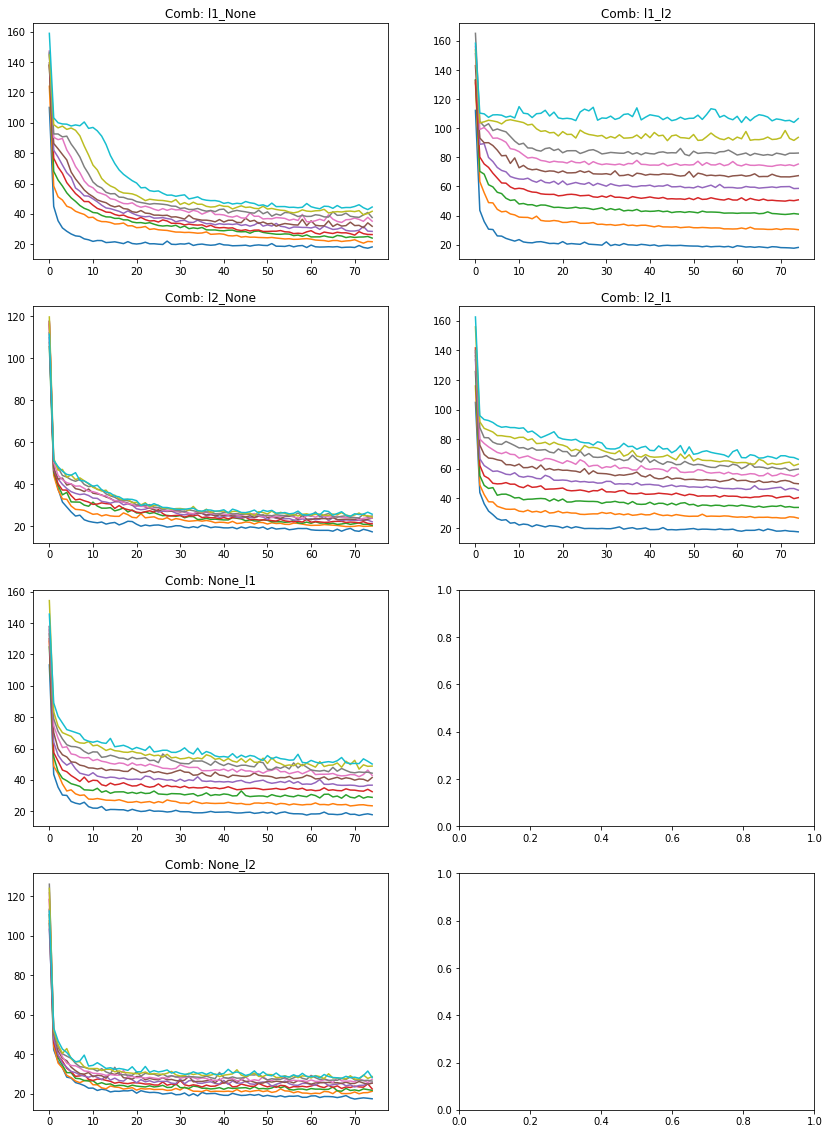

In [40]:
# Resultados sigmoid
import math


total_combinations = len(regularizer_combinations)

fig, axes = plt.subplots(nrows=4, ncols=math.ceil(total_combinations / 4), figsize=(14, 20))
fig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig_index = 0
for reg_comb in regularizer_combinations:
    
    fig_x = fig_index % 4
    fig_y = fig_index // 4
    counter = 0
    for reg_val in regularization_values:
        key = "%s_%s" % (reg_comb[0], reg_comb[1])
        
        axes[fig_x, fig_y].plot(range(0, len(regularization_results["sigmoid"][key][counter].history["loss"])), regularization_results["sigmoid"][key][counter].history["loss"], label="Regularization Value %f" % (reg_val))
        axes[fig_x, fig_y].set_title("Comb: %s" % (key))
        counter += 1
    fig_index += 1
        
plt.show()
    

# Efecto de dropout

La técnica de dropout es también una técnica de regularización. Actúa como una capa intermedia entre dos capas de las redes nueronales, haciendo que ciertas señales se anulen de forma aleatoria. Esto fuerza a la red neuronal a aprender una representación más redundante de los atributos, reduciendo así el overfitting.

### Experimentos

In [41]:
from keras.layers import Dropout
def compile_network_with_dropout(lr=0.01, hidden_units=200, hidden_activation="sigmoid", dropout_value=0.0):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
    model.add(Activation(hidden_activation))
    model.add(Dropout(dropout_value))
    model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('linear'))
    sgd = SGD(lr=lr)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model

dropout_values = np.linspace(0, 1, 10)

In [42]:
import numpy as np
dropout_results = {}

for activation in activations: 
    print(activation)
    dropout_results[activation] = []
    for drop_val in dropout_values:
        print('Checking with dropout rate %f' % (drop_val))
        random.seed(30)
        model = compile_network_with_dropout(hidden_activation=activation, dropout_value=drop_val)
        hist = fit_network(model)
        dropout_results[activation].append(hist)

sigmoid
Checking with dropout rate 0.000000
Checking with dropout rate 0.111111
Checking with dropout rate 0.222222
Checking with dropout rate 0.333333
Checking with dropout rate 0.444444
Checking with dropout rate 0.555556
Checking with dropout rate 0.666667
Checking with dropout rate 0.777778
Checking with dropout rate 0.888889
Checking with dropout rate 1.000000
relu
Checking with dropout rate 0.000000
Checking with dropout rate 0.111111
Checking with dropout rate 0.222222
Checking with dropout rate 0.333333
Checking with dropout rate 0.444444
Checking with dropout rate 0.555556
Checking with dropout rate 0.666667
Checking with dropout rate 0.777778
Checking with dropout rate 0.888889
Checking with dropout rate 1.000000


### Resultados sigmoid

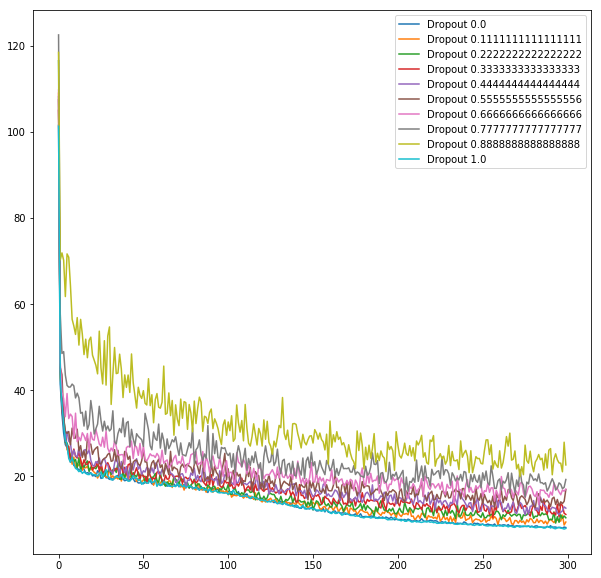

In [43]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for dropout in dropout_values:
    plt.plot(range(0, len(dropout_results["sigmoid"][counter].history["loss"])), dropout_results["sigmoid"][counter].history["loss"], label="Dropout %s" % (dropout))
    counter += 1
    
plt.legend()
plt.show()

### Resultados ReLU

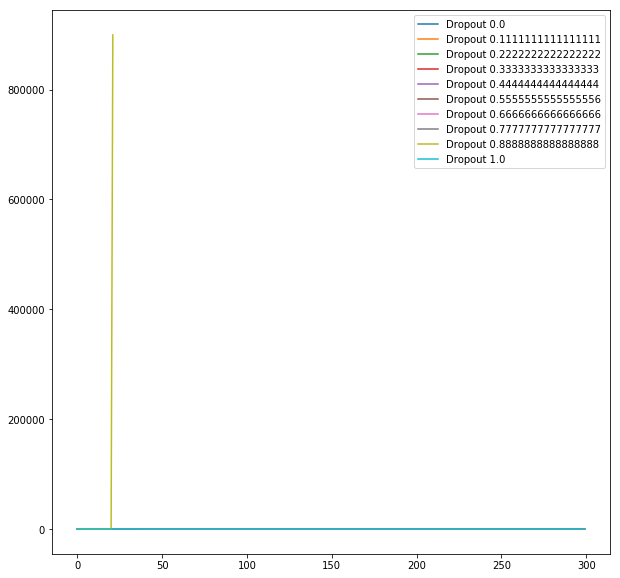

In [44]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for dropout in dropout_values:
    plt.plot(range(0, len(dropout_results["relu"][counter].history["loss"])), dropout_results["relu"][counter].history["loss"], label="Dropout %s" % (dropout))
    counter += 1
    
plt.legend()
plt.show()

# Sintonización con cross validation

La selección de parámetros es un problema muy importante en Machine Learning y en las redes neuronales. Encontrar el mejor parámetro para un problema específico se denomina sintonización y es fundamental para obtener el mejor rendimiento posible de las redes.

A continuación, se realiza la sintonización utilizando cross validation del parámetro de learning rate de la red.

Cabe notar que se utilizan solamente 100 epochs considerando que la función de perdida no mejora notablemente cuando aumenta el número de epochs, según se observó en los experimentos de learning rate realizados anteriormente.

### Experimentos

In [45]:
from sklearn import cross_validation

def evaluate_performance(learn_rate, fold_size, activation):
    Xm = X_train_scaled.as_matrix()
    ym = y_train
    kfold = cross_validation.KFold(len(Xm), fold_size)
    cvscores = []
    test_scores = []

    for i, (train, val) in enumerate(kfold):
        # create model
        model = Sequential()
        model.add(Dense(200, input_dim=len(Xm[train][0]), kernel_initializer='uniform'))
        model.add(Activation(activation))
        model.add(Dense(1, kernel_initializer='uniform'))
        model.add(Activation('linear'))
        sgd = SGD(lr=learn_rate)
        # Compile model
        model.compile(optimizer=sgd,loss='mean_squared_error')
        # Fit the model
        model.fit(Xm[train], ym[train], epochs=100, verbose=0)
        # evaluate the model
        scores = model.evaluate(Xm[val], ym[val], verbose=0)
        cvscores.append(scores)
        test_scores.append(model.evaluate(X_test_scaled, y_test, verbose=0))
        
    mse_cv = np.mean(cvscores)
    mse_test = np.mean(test_scores)
    return (cvscores, mse_cv, test_scores, mse_test)

activations = ["relu", "sigmoid"]
folds_list = [5, 10]
learn_rate_list = [
    0.00001,
    0.00005,
    0.0001,
    0.0005,
    0.0001,
    0.001,
    0.005,
    0.01,
    0.02,
    0.03,
    0.04,
    0.05
]


In [47]:
sintonization_results = {}

for activation in activations:
    sintonization_results[activation] = {}
    for folds in folds_list:
        sintonization_results[activation][folds] = []
        for learn_rate in learn_rate_list:
            (mse_cv, cvscores, test_scores, mse_test) = evaluate_performance(learn_rate, folds, activation)
            sintonization_results[activation][folds].append({
                "mse_cv": mse_cv,
                "cvscores": cvscores,
                "test_scores": test_scores,
                "mse_test": mse_test
            })

### Resultados

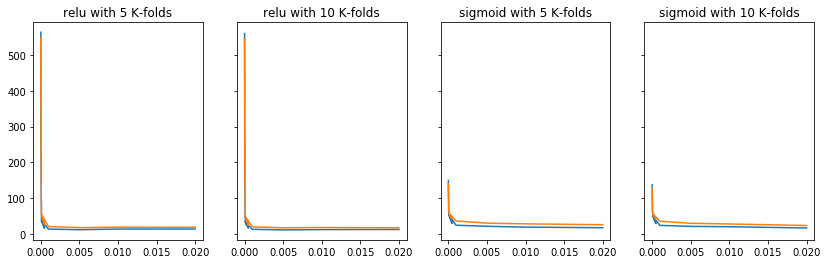

Relu 5Kfold best 0.03 0.03
Relu 10 Kfold 0.03 0.03
Sigmoid 5Kfold best 0.03 0.03
Sigmoid 10Kfold best 0.03 0.03


In [77]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 4), sharey=True)


plot_index = 0
for activation in activations:
    for folds in folds_list:
        counter = 0
        cv_result = []
        test_result = []
        for learn_rate in learn_rate_list:
            results = sintonization_results[activation][folds][counter]
            cv_result.append(results["cvscores"])
            test_result.append(results["mse_test"])
            counter += 1
        axes[plot_index].plot(learn_rate_list, cv_result)
        axes[plot_index].plot(learn_rate_list, test_result)
        axes[plot_index].set_title("%s with %d K-folds" % (activation, folds))
        plot_index += 1
    
plt.legend()
plt.show()

# Get a list of cvscores
list1_cv = [elem["cvscores"] for elem in sintonization_results["relu"][5]]
list1_test = [elem["mse_test"] for elem in sintonization_results["relu"][5]]


list2_cv = [elem["cvscores"] for elem in sintonization_results["relu"][10]]
list2_test = [elem["mse_test"] for elem in sintonization_results["relu"][10]]

list3_cv = [elem["cvscores"] for elem in sintonization_results["sigmoid"][5]]
list3_test = [elem["mse_test"] for elem in sintonization_results["sigmoid"][5]]

list4_cv = [elem["cvscores"] for elem in sintonization_results["sigmoid"][10]]
list4_test = [elem["mse_test"] for elem in sintonization_results["sigmoid"][10]]


max1_cv = np.argmax(list1_cv)
max1_test = np.argmax(list1_test)

max2_cv = np.argmax(list2_cv)
max2_test = np.argmax(list2_test)

max3_cv = np.argmax(list3_cv)
max3_test = np.argmax(list3_test)

max4_cv = np.argmax(list4_cv)
max4_test = np.argmax(list4_test)

print("Relu 5Kfold best", learn_rate_list[max1_cv], learn_rate_list[max1_test])
print("Relu 10 Kfold",  learn_rate_list[max2_cv], learn_rate_list[max2_test])
print("Sigmoid 5Kfold best", learn_rate_list[max3_cv], learn_rate_list[max3_test])
print("Sigmoid 10Kfold best", learn_rate_list[max4_cv], learn_rate_list[max4_test])